In [12]:
import re

import io
from tqdm import tqdm

import pandas as pd
import numpy as np

import emoji

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras.layers import TextVectorization

# Loading Embeddings

In [3]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [4]:
def load_glove(fname):
    embeddings_index = {}
    with open(fname, encoding="utf8") as f:
        for line in tqdm(f):
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    
    return embeddings_index

In [5]:
parameters = {}
parameters['embedding_name'] = './embeddings/glove.twitter.27B.100d.txt'
parameters['save_path'] = 'models/text_emotion_cnn_embeddings/'

In [6]:
embedding_index = load_glove(parameters['embedding_name'])
print('Number of word vectors : ', len(embedding_index))

1193514it [00:51, 22998.17it/s]

Number of word vectors :  1193514


## Reading and Pre-processing

In [7]:
df = pd.read_csv('../Data/text_emotion.csv')

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                   "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [9]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [10]:
def clean_text(data):
    data = (re.sub(r"(#[\d\w\.]+)", '', data)).lower()
    data = emoji.demojize(data)
    data = spacy_cleaner(data)
    return data

In [13]:
df['text'] = df['content'].apply(clean_text)

<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\ '
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\l'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\|'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\m'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\/'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequence '\o'
  decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
<ipython-input-9-7d9fec89b443>:9: DeprecationWarning: invalid escape sequenc

In [14]:
classes = sorted(list(set(df['sentiment'])))
no_classes = len(classes)

class_mapping = {}
for idx, name in enumerate(classes):
    class_mapping[name] = idx 

In [15]:
_ = df.pop('tweet_id')
_ = df.pop('author')

In [16]:
df['label'] = df['sentiment'].apply(lambda x : class_mapping[x])

In [17]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [18]:
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

train_dataset = build_dataset(df_train)
val_dataset = build_dataset(df_val)
test_dataset = build_dataset(df_test)

In [19]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128

In [20]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model

In [21]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [22]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'be', 'to', 'the']

In [23]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [24]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16297 words (3475 misses)


In [25]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [26]:
x_train = vectorizer(np.array([[s] for s in list(df_train.text)])).numpy()
x_val = vectorizer(np.array([[s] for s in list(df_val.text)])).numpy()

y_train = np.array(list(df_train.label))
y_val = np.array(list(df_val.label))

In [27]:
import os
def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

## Custom Callback

Custom callback to save the model that gives the best F1 score

In [28]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class CustomCallback(Callback):
    def __init__(self, validation_data=None):
        super(CustomCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_train_begin(self, logs={}):        
        self.best_f1 = 0

    def on_epoch_end(self, epoch, logs={}):        
        val_predict = (np.asarray(self.model.predict(self.validation_data[0])))
        val_predict = [np.argmax(i) for i in val_predict]
        
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average = 'weighted')
        _val_recall = recall_score(val_targ, val_predict, average = 'weighted')
        _val_precision = precision_score(val_targ, val_predict, average = 'weighted')
        
        print("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        
        if _val_f1 > self.best_f1:
            make_dir(parameters['save_path'])
            self.model.save_weights(f"{parameters['save_path']}")
            self.best_f1 = _val_f1
            
            print("saving...")
        
        return

## Model Definition

In [32]:
from tensorflow.keras import layers

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
embedded_sequences.trainable = False 
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(no_classes, activation="softmax")(x)
model = tf.keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1977400   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         8204

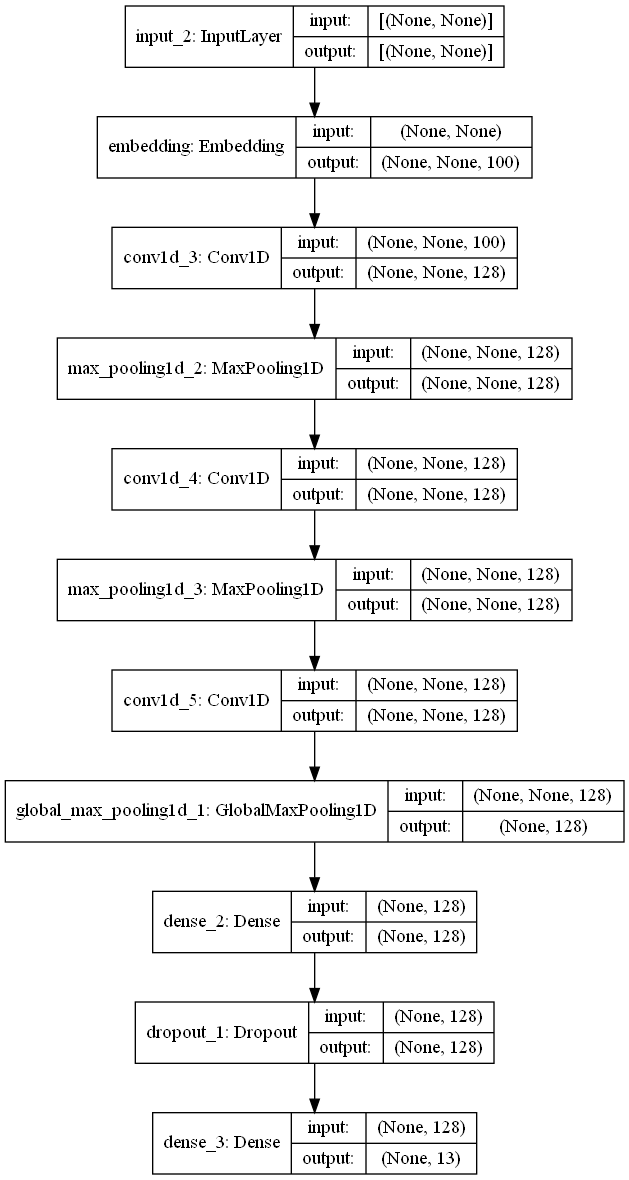

In [42]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Model Training

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                    batch_size=128, epochs=15, shuffle = True, 
                    callbacks = [CustomCallback(validation_data = (x_val, y_val))])

Epoch 1/15
200/200 [==============================] - 13s 60ms/step - loss: 2.1269 - accuracy: 0.2627 - val_loss: 1.9702 - val_accuracy: 0.3250
— val_f1: 0.250959 — val_precision: 0.222973 — val_recall 0.325000
saving...
Epoch 2/15
  1/200 [..............................] - ETA: 10s - loss: 2.0051 - accuracy: 0.3359

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 16s 78ms/step - loss: 1.9511 - accuracy: 0.3348 - val_loss: 1.9160 - val_accuracy: 0.3397
— val_f1: 0.268056 — val_precision: 0.232499 — val_recall 0.339687
saving...
Epoch 3/15
  1/200 [..............................] - ETA: 13s - loss: 1.9355 - accuracy: 0.3828

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 14s 71ms/step - loss: 1.8650 - accuracy: 0.3661 - val_loss: 1.9714 - val_accuracy: 0.3316
— val_f1: 0.285201 — val_precision: 0.317459 — val_recall 0.331562
saving...
Epoch 4/15
  1/200 [..............................] - ETA: 11s - loss: 1.8203 - accuracy: 0.3125

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 16s 79ms/step - loss: 1.7828 - accuracy: 0.3959 - val_loss: 1.9278 - val_accuracy: 0.3445
— val_f1: 0.281653 — val_precision: 0.323688 — val_recall 0.344531
Epoch 5/15
  2/200 [..............................] - ETA: 12s - loss: 1.6828 - accuracy: 0.4609

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 14s 68ms/step - loss: 1.6795 - accuracy: 0.4342 - val_loss: 2.0014 - val_accuracy: 0.3383
— val_f1: 0.284934 — val_precision: 0.297248 — val_recall 0.338281
Epoch 6/15
  3/200 [..............................] - ETA: 11s - loss: 1.4776 - accuracy: 0.5026

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 15s 73ms/step - loss: 1.5688 - accuracy: 0.4738 - val_loss: 2.1120 - val_accuracy: 0.3309
— val_f1: 0.291448 — val_precision: 0.272058 — val_recall 0.330937
saving...
Epoch 7/15
  1/200 [..............................] - ETA: 10s - loss: 1.2465 - accuracy: 0.5781

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 14s 71ms/step - loss: 1.4507 - accuracy: 0.5089 - val_loss: 2.1704 - val_accuracy: 0.3283
— val_f1: 0.291423 — val_precision: 0.283046 — val_recall 0.328281
Epoch 8/15
  3/200 [..............................] - ETA: 11s - loss: 1.3483 - accuracy: 0.5391

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 14s 70ms/step - loss: 1.3528 - accuracy: 0.5396 - val_loss: 2.3382 - val_accuracy: 0.3119
— val_f1: 0.276119 — val_precision: 0.265907 — val_recall 0.311875
Epoch 9/15
  3/200 [..............................] - ETA: 11s - loss: 1.2081 - accuracy: 0.5964

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 14s 71ms/step - loss: 1.2461 - accuracy: 0.5737 - val_loss: 2.5976 - val_accuracy: 0.3127
— val_f1: 0.280138 — val_precision: 0.278667 — val_recall 0.312656
Epoch 10/15
  2/200 [..............................] - ETA: 12s - loss: 1.0847 - accuracy: 0.6406

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 15s 78ms/step - loss: 1.1617 - accuracy: 0.5996 - val_loss: 2.6991 - val_accuracy: 0.3067
— val_f1: 0.280359 — val_precision: 0.268246 — val_recall 0.306719
Epoch 11/15
  2/200 [..............................] - ETA: 12s - loss: 1.0470 - accuracy: 0.6250

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 15s 73ms/step - loss: 1.0735 - accuracy: 0.6294 - val_loss: 3.0552 - val_accuracy: 0.3072
— val_f1: 0.276315 — val_precision: 0.274756 — val_recall 0.307188
Epoch 12/15
  2/200 [..............................] - ETA: 13s - loss: 0.8937 - accuracy: 0.6914

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 15s 76ms/step - loss: 1.0084 - accuracy: 0.6519 - val_loss: 3.2986 - val_accuracy: 0.2958
— val_f1: 0.270876 — val_precision: 0.274912 — val_recall 0.295781
Epoch 13/15
  2/200 [..............................] - ETA: 12s - loss: 0.9050 - accuracy: 0.6953

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 14s 71ms/step - loss: 0.9522 - accuracy: 0.6711 - val_loss: 3.2090 - val_accuracy: 0.2783
— val_f1: 0.270954 — val_precision: 0.270794 — val_recall 0.278281
Epoch 14/15
  2/200 [..............................] - ETA: 13s - loss: 0.7870 - accuracy: 0.7305

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 14s 71ms/step - loss: 0.8861 - accuracy: 0.6963 - val_loss: 3.4678 - val_accuracy: 0.2780
— val_f1: 0.269004 — val_precision: 0.265752 — val_recall 0.277969
Epoch 15/15
  2/200 [..............................] - ETA: 12s - loss: 0.8165 - accuracy: 0.7344

C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200/200 [==============================] - 15s 74ms/step - loss: 0.8360 - accuracy: 0.7133 - val_loss: 3.6004 - val_accuracy: 0.2664
— val_f1: 0.261635 — val_precision: 0.259352 — val_recall 0.266406


C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


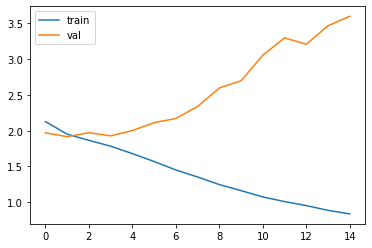

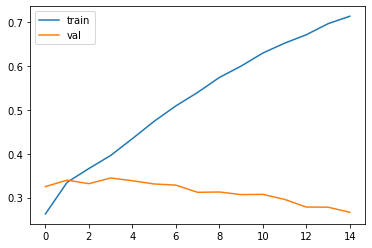

In [34]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

## Evaluation against test data

In [35]:
x_test = vectorizer(np.array([[s] for s in list(df_test.text)])).numpy()
y_test = np.array(list(df_test.label))

In [36]:
model.load_weights(parameters['save_path'])

In [37]:
model.evaluate(x_test, y_test)

250/250 [==============================] - 2s 7ms/step - loss: 2.0791 - accuracy: 0.3404


[2.079133987426758, 0.34037500619888306]

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [39]:
pred = model.predict(x_test)

pred_idx = []

for i in tqdm(range(len(pred))):
    pred_idx.append(np.argmax(pred[i]))

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 258063.37it/s]


In [40]:
print(classification_report(y_test, pred_idx, target_names=classes))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        22
     boredom       0.00      0.00      0.00        34
       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       122
         fun       0.00      0.00      0.00       372
   happiness       0.30      0.34      0.32      1037
        hate       0.30      0.25      0.27       263
        love       0.36      0.47      0.40       753
     neutral       0.36      0.56      0.43      1735
      relief       0.00      0.00      0.00       310
     sadness       0.35      0.21      0.26      1050
    surprise       0.00      0.00      0.00       453
       worry       0.34      0.46      0.39      1684

    accuracy                           0.34      8000
   macro avg       0.15      0.18      0.16      8000
weighted avg       0.28      0.34      0.30      8000



C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\soham\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
print(confusion_matrix(y_test, pred_idx))

[[  0   0   0   0   0   2   3   0   5   0   2   0  10]
 [  0   0   0   0   0   3   2   1   9   0   9   0  10]
 [  0   0   0   0   0  11   6   4  91   0   8   0  45]
 [  0   0   0   0   0  29   0  10  51   0   5   0  27]
 [  0   0   0   0   0 102   4  48 128   0  16   0  74]
 [  0   0   0   0   0 355   7 234 282   0  25   0 134]
 [  0   0   0   0   0   6  65   9  60   0  26   0  97]
 [  0   0   0   0   0 156   6 351 123   0  29   0  88]
 [  0   0   0   0   0 220  32 102 964   0  65   0 352]
 [  0   0   0   0   0  56   2  43 103   0   8   0  98]
 [  0   0   0   0   0  55  38  59 235   0 218   0 445]
 [  0   0   0   0   0  80  11  41 169   0  30   0 122]
 [  0   0   0   0   0 122  44  79 481   0 188   0 770]]
